In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn.preprocessing as preprocessing
import statsmodels.api as sm

from datetime import datetime
from IPython.display import display
from itertools import combinations
from matplotlib.ticker import MaxNLocator
from numpy.testing import assert_almost_equal
from sklearn.decomposition import PCA
from statsmodels.stats.proportion import proportions_ztest

# Custom output options.
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
sns.set_style('whitegrid')
sns.set_context('paper')
plt.rcParams['figure.figsize'] = 8, 5 # default 6x4
%matplotlib inline

# default folder to save LaTEX strings with save_df_latex().
DF_LATEX_FOLDER = 'am205_report_Yihang\\jupyter_tables\\'

CRYPTO_FILES = [('ripple_price', 'rip'), ('bitcoin_price', 'btc'),
                ('ethereum_price', 'eth'), ('litecoin_price', 'ltc'),
                ('monero_price', 'mon'), ('nem_price', 'nem'),
                ('dash_price', 'dash')]

BSK_FILES = [('AAPL', 'AAPL'), ('GLD', 'GLD'), ('HYG', 'HYG'), 
             ('X', 'X'), ('GE', 'GE'), ('M', 'M'), ('MOS', 'MOS')]

XLE_FILES = [('COP_data', 'COP'), ('CVX_data', 'CVX'),
                ('EOG_data', 'EOG'), ('OXY_data', 'OXY'),
                ('PSX_data', 'PSX'), ('SLB_data', 'SLB'),
                ('XOM_data', 'XOM')]

C:\Users\Nathaniel\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#####################################################################
# Utils used throughout the notebook to read/write data, perform  
# commonly used computations. 
#####################################################################

def load_returns_matrix (files, tdelta=pd.Timedelta(days=30), center=True, 
                         scale=True):
    """Returns cryptocurrency rolling returns for which a price level is 
    available for all the assets.
    
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_adj (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'cryptocurrencypricehistory//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close'])
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    first_date = min(dfout.index)
    last_date = max(dfout.index)
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_adj = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_adj


def load_xle_returns (files, tdelta=pd.Timedelta(days=30), center=True, 
                      scale=True, start=None, end=None):
    """Returns top XLE components' rolling returns.
        
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_std (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'XLE//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['Date', 'Close']).iloc[::-1]
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[['Date', 'Close']]
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    
    # Filter time frame.
    if start is not None:
        dfout = dfout[dfout.index >= start]
    if end is not None:
        dfout = dfout[dfout.index <= end]
    
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_std = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_std

def load_other_returns (files, tdelta=pd.Timedelta(days=30), center=True, 
                        scale=True, start=None, end=None):
    """Creates rolling-return DataFrame for assets in files in other_assets 
    folder.
        
    Args:
        files (list of tuples): (asset name, file path) tuples. Asset name 
            used in column headers for DF.
        
    Returns:
        dfout (DataFrame): Returns without centering/scaling.
        dfout_std (DataFrame): Returns with centering/scaling (depending 
            on input vals for center and scale).
    """
    dfs = []
    for file, name in files:
        path = 'other_assets//{}.csv'.format(file)
        df = pd.read_csv(path, usecols=['date', 'close'])
        df['date'] = pd.to_datetime(df['date'])
        df.columns = ['Date', 'Close']
        df.set_index('Date', drop=True, inplace=True)
        df.rename(columns={'Close':name}, inplace=True)
        dfs.append(df)
    dfout = pd.concat(dfs, axis=1, join='inner')
    first_date = min(dfout.index)
    last_date = max(dfout.index)
    dfout = dfout.pct_change(periods=1, freq=tdelta)
    dfout.dropna(axis=0, how='any', inplace=True)
    
    # Filter time frame.
    if start is not None:
        dfout = dfout[dfout.index >= start]
    if end is not None:
        dfout = dfout[dfout.index <= end]
    
    xout = preprocessing.scale(dfout, axis=0, with_mean=center, with_std=scale)
    dfout_std = pd.DataFrame(xout, columns=dfout.columns, index=dfout.index)
    return dfout, dfout_std

def create_proportion_of_variation_df (eigvals):
    total_var = sum(eigvals)
    cols = ['Component', 'Eigenvalue', 'Proportion', 'Cumulative']
    df = pd.DataFrame(columns=cols)
    cum = 0
    for i, e in enumerate(eigvals):
        cum += e
        row = {'Component':i + 1,
               'Eigenvalue':e,
               'Proportion':e/total_var,
               'Cumulative':cum/total_var}
        df = df.append(row, ignore_index=True)
    df['Component'] = df['Component'].astype(int)
    df.set_index('Component', drop=True, inplace=True)
    return df


def create_eigvec_df (eigvecs):
    """Create DataFrame of eigenvectors."""
    idx = [i + 1 for i in range(len(eigvecs))]
    df = pd.DataFrame(index=idx)
    for i, v in enumerate(eigvecs):
        df['V{}'.format(i + 1)] = v
    return df

def get_variation_loadings(df):
    """Computes proportion of variation explained (using eigenvalues) 
    and loadings of column variables on principal components.
    
    Args:
        df (DataFrame): Time series with columns representing assets.
    
    Returns:
        df_variation (DataFrame): Contains eigenvalues and proportion of 
            variation explained.
        df_loadings (DataFrame): Loadings for each principal component 
            on assets. Columns returned may be in different order than 
            they appear in df since they are sorted according to the 
            order of the eigenvalue magnitude.    
    """
    # Get SVD breakdown, cast into matrices.
    cov = np.cov(df.values.T)
    eig_vals, eig_vecs = np.linalg.eig(cov)
    # Create list of (eigenvalue, eigenvector, i) tuples
    # where i represents original ordering (for use in column names).
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i], i) 
                 for i in range(len(eig_vals))]
    
    # Sort from high to low, then extract now-sorted eigenvalues and 
    # eigenvectors.
    eig_pairs.sort(key = lambda x: x[0], reverse= True)
    eig_vecs = [epair[1] for epair in eig_pairs]
    eig_vals = np.array([epair[0] for epair in eig_pairs])
    newcol_indxs = [epair[2] for epair in eig_pairs]
    newcols = [df.columns[i] for i in newcol_indxs]
    
    # Create matrix with eigenvectors in columns.
    V = np.column_stack(eig_vecs)
    
    df_variation = create_proportion_of_variation_df(eig_vals)
    loadings = np.multiply(V, np.sqrt(eig_vals)).T
    newcols = [df.columns[e[2]] for e in eig_pairs]
    
    p = len(df.columns) # number of variables
    idx = pd.Series([i + 1 for i in range(p)], name='Component')
    df_loadings = pd.DataFrame(loadings, columns=newcols, index=idx)
    
    return df_variation, df_loadings 

def save_df_latex(df, filename, dec=None, folder=DF_LATEX_FOLDER):
    """Saves DataFrame to Latex in notebook-defined folder."""
    if filename[-4:] != '.txt': filename += '.txt'
    path = DF_LATEX_FOLDER + filename
    if dec is None: s = df.to_latex()
    else: s = df.round(dec).to_latex()
    
    with open(path, "w") as text_file:
        text_file.write(s)
        
def sxn_break(x):
    print(x)
    print('-'*30)

## Cryptocurrency returns analysis

In [3]:
# Init data and obtain covariance matrix.
cryp_unadj, cryp_std = load_returns_matrix(CRYPTO_FILES)

analysis_start_dt = min(cryp_std.index)
analysis_end_dt = max(cryp_std.index)

print('Number of returns in data: {}'.format(len(cryp_std.index)))
print('Analysis start date: {}'.format(analysis_start_dt))
print('Analysis end date: {}'.format(analysis_end_dt))

Number of returns in data: 794
Analysis start date: 2015-09-06 00:00:00
Analysis end date: 2017-11-07 00:00:00


### Basic features of unstandardized price return data

In [4]:
print('Price return statistics without centering/scaling:')
print('Mean returns:')
display(cryp_unadj.mean(axis=0))
print('S.D. of returns:')
display(cryp_unadj.std(axis=0))
print('Cumulative return:')
display((cryp_unadj + 1).prod(axis=0))
print('Correlation:')
cryp_unadj.corr()

Price return statistics without centering/scaling:
Mean returns:


rip     0.395
btc     0.150
eth     0.410
ltc     0.173
mon     0.364
nem     0.585
dash    0.277
dtype: float64

S.D. of returns:


rip     1.468
btc     0.232
eth     0.836
ltc     0.475
mon     0.873
nem     1.190
dash    0.620
dtype: float64

Cumulative return:


rip     1.841e+43
btc     8.094e+41
eth     2.544e+71
ltc     7.702e+36
mon     3.682e+66
nem     1.561e+98
dash    3.883e+60
dtype: float64

Correlation:


,rip,btc,eth,ltc,mon,nem,dash
rip,1.000,0.305,0.325,0.694,0.066,0.630,0.037
btc,0.305,1.000,0.164,0.322,0.102,0.349,0.031
eth,0.325,0.164,1.000,0.192,0.171,0.361,0.470
ltc,0.694,0.322,0.192,1.000,0.044,0.428,0.018
mon,0.066,0.102,0.171,0.044,1.000,0.114,0.128
nem,0.630,0.349,0.361,0.428,0.114,1.000,0.133
dash,0.037,0.031,0.470,0.018,0.128,0.133,1.000


### Proportion of Variation Explained

In [5]:
cryp_variation, cryp_loadings = get_variation_loadings(cryp_std)
display(cryp_variation.round(3))

,Eigenvalue,Proportion,Cumulative
Component,,,
1,2.657,0.379,0.379
2,1.376,0.196,0.575
3,0.941,0.134,0.710
4,0.769,0.110,0.819
5,0.564,0.080,0.900
6,0.464,0.066,0.966
7,0.239,0.034,1.000


### Loadings

In [6]:
display(cryp_loadings.round(3))

,rip,btc,ltc,mon,nem,dash,eth
Component,,,,,,,
1,0.844,0.544,0.583,0.742,0.224,0.793,0.284
2,0.278,0.176,-0.596,0.363,-0.383,0.074,-0.793
3,-0.102,0.296,-0.198,-0.063,0.853,-0.036,-0.266
4,-0.250,0.760,0.006,-0.198,-0.273,-0.039,0.114
5,-0.011,-0.071,0.171,-0.459,-0.042,0.481,-0.293
6,-0.009,-0.043,-0.485,-0.059,0.018,0.321,0.346
7,0.373,0.044,-0.058,-0.250,0.006,-0.171,0.051


# Are cryptocurrencies an asset class?

## Taking a look at energy (XLE) and a random basket

In [7]:
#####################################################################
# Load reference datasets and filter to be in same time frame as 
# cryptos. Compute their proportion-of-variations and loadings.
#####################################################################

USE_SAME_TIMEFRAME_AS_CRYPTO = True

if USE_SAME_TIMEFRAME_AS_CRYPTO:
    start_date, end_date = analysis_start_dt, analysis_end_dt
else:
    start_date, end_date = None, None
    
# Load energy and basket returns data.
XLE_df, XLE_df_std = load_xle_returns(XLE_FILES, start=start_date, end=end_date)
bsk_df, bsk_df_std = load_other_returns(BSK_FILES, start=start_date, end=end_date)

# Limit both DFs to overlapping time frames if we're not limiting them 
# to crypto time frame.
if not USE_SAME_TIMEFRAME_AS_CRYPTO:
    common_idx = XLE_df.index.intersection(bsk_df.index)
    XLE_df, XLE_df_std = XLE_df.loc[common_idx], XLE_df_std.loc[common_idx]
    bsk_df, bsk_df_std = bsk_df.loc[common_idx], bsk_df_std.loc[common_idx]
        
xle_variation, xle_loadings = get_variation_loadings(XLE_df_std)
bsk_variation, bsk_loadings = get_variation_loadings(bsk_df_std)

print('XLE returns in data: {}'.format(len(XLE_df_std.index)))
print('Basket returns in data: {}'.format(len(bsk_df_std.index)))

XLE returns in data: 284
Basket returns in data: 320


### Proportion of variation explained & loadings

In [8]:
sxn_break('Proportion of variation')
print('XLE')
display(xle_variation.round(3))
print('\nBasket')
display(bsk_variation.round(3))

sxn_break('\nLoadings')
print('XLE')
display(xle_loadings.round(3))
print('\nBasket')
display(bsk_loadings.round(3))

#save_df_latex(xle_loadings, 'XLE loadings', dec=3)
#save_df_latex(bsk_loadings, 'Basket loadings', dec=3)

Proportion of variation
------------------------------
XLE


,Eigenvalue,Proportion,Cumulative
Component,,,
1,4.642,0.661,0.661
2,0.842,0.120,0.781
3,0.549,0.078,0.859
4,0.476,0.068,0.927
5,0.227,0.032,0.959
6,0.175,0.025,0.984
7,0.113,0.016,1.000



Basket


,Eigenvalue,Proportion,Cumulative
Component,,,
1,2.651,0.377,0.377
2,1.181,0.168,0.546
3,1.051,0.150,0.695
4,0.822,0.117,0.812
5,0.633,0.090,0.902
6,0.396,0.056,0.959
7,0.289,0.041,1.000



Loadings
------------------------------
XLE


,COP,CVX,EOG,OXY,XOM,SLB,PSX
Component,,,,,,,
1,0.772,0.886,0.870,0.854,0.663,0.841,0.793
2,0.426,0.016,0.096,-0.367,0.559,-0.186,-0.413
3,-0.240,-0.374,0.261,0.159,0.142,0.370,-0.318
4,-0.359,0.007,-0.241,-0.016,0.478,-0.021,0.245
5,-0.022,-0.136,0.205,0.200,0.048,-0.347,0.062
6,0.159,-0.089,-0.263,0.254,0.037,0.007,-0.079
7,0.123,-0.225,-0.001,-0.102,0.000,0.055,0.184



Basket


,AAPL,X,M,MOS,GE,HYG,GLD
Component,,,,,,,
1,-0.349,-0.135,-0.694,-0.861,-0.491,-0.599,-0.829
2,-0.776,0.512,-0.346,0.132,0.024,0.413,0.084
3,-0.269,-0.733,-0.366,0.087,0.533,0.015,0.122
4,-0.113,0.369,0.159,-0.123,0.589,-0.534,0.018
5,-0.385,-0.183,0.269,0.039,-0.345,-0.341,0.377
6,0.183,0.114,-0.396,0.297,-0.103,-0.254,0.171
7,0.108,0.048,-0.118,-0.362,0.016,0.088,0.349


## Proportion z-test

In [9]:
def count_same_sign(df, column_pair, n_comp):
    """Computes number of times loadings are of the same sign for pair of 
    assets among n_comp components.
    
    Args:
        df (DataFrame): Contains loadings for each asset against component 
            number (index). Assumes that the loadings for the first 
            component are in the first row, the second component the second
            row, etc.
        column_pair (Sequence of length 2): Contains pair of column names 
            for assets whose loadings we want to compare.
        n_comp (int): Number of components to compare the two assets on.
    
    Returns:
        ss_count (int): Number of times loadings are of the same sign.
    """
    ss_count = 0
    x1, x2 = column_pair
    for i in range(n_comp):
        loadings = [df.iloc[i][x1], df.iloc[i][x2]]
        signs = [int(s) for s in np.sign(loadings)]
        if abs(sum(signs)) == 2:
            ss_count += 1
    return ss_count

In [10]:
# Perform proportion z-test using proportion of times the crypto pair 
# had the same loading signs.

def get_same_sign_count_df(df_loadings, ncomp):
    asset_pairs = list(combinations(df_loadings.columns, 2))
    data_rows = []
    for pair in asset_pairs:
        count = count_same_sign(df_loadings, pair, n_comp=ncomp)
        data_rows.append([pair[0], pair[1], count])
    cols = ['Asset 1', 'Asset 2', 'Same Sign Loading']
    df = pd.DataFrame(data_rows, columns=cols)
    return df

def perform_proportion_ztest(ss_df, ncomp, null_hypo_value = 0.5):
    """Performs proportion z-test on DF containing number of same-sign pairs."""    
    ss_counts = ss_df['Same Sign Loading'].tolist()
    total_same_sign = sum(ss_counts)
    total_obs = ncomp * len(ss_df.index)
    return proportions_ztest(total_same_sign, 
                             nobs=total_obs, 
                             value=null_hypo_value,
                             alternative='larger', 
                             prop_var=null_hypo_value)

In [11]:
# Prepare DataFrame storing number of times the loadings for a pair of 
# assets have the same signs for a certain number of PCs.

# Number of components to check loadings for.
ss_ncomp_cryp = 5
ss_ncomp_xle = 4
ss_ncomp_bsk = 6

cryp_ss_df = get_same_sign_count_df(cryp_loadings, ss_ncomp_cryp)
xle_ss_df = get_same_sign_count_df(xle_loadings, ss_ncomp_xle)
bsk_ss_df = get_same_sign_count_df(bsk_loadings, ss_ncomp_bsk)

# Conduct tests for each set of assets and store results in DF.
proptest_results = []

# Cryptos
zstat, pval = perform_proportion_ztest(cryp_ss_df, ss_ncomp_cryp)
prop_var = cryp_variation.at[ss_ncomp_cryp, 'Cumulative']
proptest_results.append([ss_ncomp_cryp, zstat, pval, prop_var])

# Energy
zstat, pval = perform_proportion_ztest(xle_ss_df, ss_ncomp_xle)
prop_var = xle_variation.at[ss_ncomp_xle, 'Cumulative']
proptest_results.append([ss_ncomp_xle, zstat, pval, prop_var])

# Basket
zstat, pval = perform_proportion_ztest(bsk_ss_df, ss_ncomp_bsk)
prop_var = bsk_variation.at[ss_ncomp_bsk, 'Cumulative']
proptest_results.append([ss_ncomp_bsk, zstat, pval, prop_var])

proptest_results = np.array(proptest_results).T
proptest_results = pd.DataFrame(
    proptest_results, columns=['Crypto', 'Energy', 'Basket'],
    index=['Components', '$z$', '$p$-value', '$\sigma^2$'])

display(proptest_results)
#save_df_latex(proptest_results, 'proportion test results', dec=3)

,Crypto,Energy,Basket
Components,5.000,4.000,6.000
$z$,1.659,1.309,0.891
$p$-value,0.049,0.095,0.186
$\sigma^2$,0.900,0.927,0.959


## Inter-temporal consistency of covariance matrix

*Fit regression model to forecast loadings in time period 2 based on time period 1.*

In [60]:
#####################################################################
# Model params.

SAVE_TIMETEST_FIGS = True
TT_ASSET = 'Crypto'
df_tt = cryp_unadj.copy()  # DF of UNSTANDARDIZED asset returns to model

ncomp = 1  # number of components from which to use loadings
ndays = 90  # size of time periods
tstep = 10  # number of rows to jump in setting next time period 1
last_i = len(df_tt.index) - 2*ndays + 1
time_results = []

####################################################################
# Run model.

for i in range(0, last_i, tstep):
    idx1 = i + ndays
    
    # First time period DF.
    df_t1 = df_tt.iloc[i:idx1]
    X_t1 = preprocessing.scale(df_t1, axis=0, with_mean=True, with_std=True)
    df_t1_std = pd.DataFrame(X_t1, columns=df_t1.columns, index=df_t1.index)
    _, loadings_t1 = get_variation_loadings(df_t1_std)
    
    # Second time period DF.
    df_t2 = df_tt.iloc[idx1:idx1+ndays-1]
    X_t2 = preprocessing.scale(df_t2, axis=0, with_mean=True, with_std=True)
    df_t2_std = pd.DataFrame(X_t2, columns=df_t2.columns, index=df_t2.index)
    _, loadings_t2 = get_variation_loadings(df_t2_std)
    
    if i == 0 or i == 10:
        print(min(df_t1.index), max(df_t1.index))
        print(min(df_t2.index), max(df_t2.index))
    
    # Prepare regression data.
    df_x = pd.DataFrame()
    df_x['t1_load'] = np.ravel(loadings_t1.values)
    df_x['intercept'] = 1
    Y = np.ravel(loadings_t2.values)
    model = sm.OLS(Y, df_x).fit()
    results = [df_tt.iloc[i].name, model.rsquared, model.f_pvalue]
    time_results.append(results)

2015-09-06 00:00:00 2015-12-04 00:00:00
2015-12-05 00:00:00 2016-03-02 00:00:00
2015-09-16 00:00:00 2015-12-14 00:00:00
2015-12-15 00:00:00 2016-03-12 00:00:00


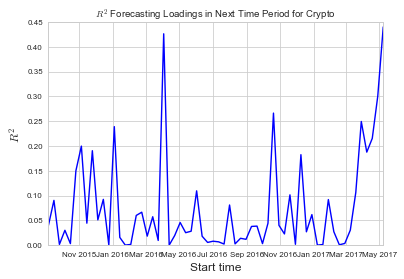

In [61]:
x = [t[0] for t in time_results]
y = [t[1] for t in time_results]
plt.xlabel('Start time', fontsize=12)
plt.ylabel('$R^2$', fontsize=12)
plt.title('$R^2$ Forecasting Loadings in Next Time Period for {}'.format(TT_ASSET))
plt.plot(x, y)
if SAVE_TIMETEST_FIGS:
    path = '{}//{} R2 {}D.png'.format(DF_LATEX_FOLDER, TT_ASSET, ndays)
    plt.savefig(path, bbox_inches='tight')

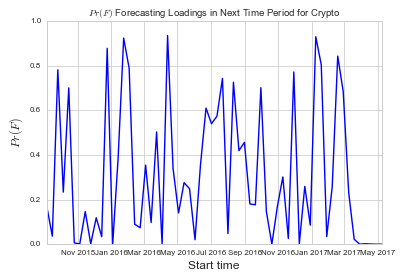

In [62]:
x = [t[0] for t in time_results]
y = [t[2] for t in time_results]
plt.xlabel('Start time', fontsize=12)
plt.ylabel('$Pr(F)$', fontsize=12)
plt.title('$Pr(F)$ Forecasting Loadings in Next Time Period for {}'.format(TT_ASSET))
plt.plot(x, y)
if SAVE_TIMETEST_FIGS:
    path = '{}//{} F {}D.png'.format(DF_LATEX_FOLDER, TT_ASSET, ndays)
    plt.savefig(path, bbox_inches='tight')